In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import yaml

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric

np.random.seed(2112)
pd.set_option('display.max_columns', None)

In [2]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jupyterlab"

In [3]:
lgb.__version__

'3.3.2'

***
## load and prepare data

In [4]:
!ls ../data/processed/dsv04

test.parquet  train.parquet


In [5]:
train = pd.read_parquet("../data/processed/dsv04/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
len(input_feats)

1639

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
train = train.reset_index()

del train_labels
gc.collect()

0

***
## model tuning

train with repeated cross validation

In [8]:
skf = StratifiedKFold(n_splits=3, random_state=2112, shuffle=True)
skf_split = list(skf.split(train, train["target"].values))

In [9]:
default_params = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.05,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 2112,
    'verbosity': -1,
    'bin_construct_sample_cnt': 100000000,
    'feature_pre_filter': True,
}

In [10]:
def train_models(dataframe: pd.DataFrame, split: list, model_params: dict) -> pd.DataFrame:
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for train_idx,valid_idx in split:
        
        train_df = dataframe.loc[train_idx,:]
        valid_df = dataframe.loc[valid_idx,:]
        
        train_dset = lgb.Dataset(
            data=train_df[input_feats],
            label=train_df["target"].values,
            free_raw_data=True
        )        
        model = lgb.train(
            params=model_params,
            train_set=train_dset
        )        
        oof.loc[valid_idx,"pred"] = model.predict(valid_df[input_feats])
            
        del train_dset,model
        gc.collect()
    
    return oof

In [11]:
def objective(trial):
    sampled_params = dict(
        # general booster config
        max_bin = 2**trial.suggest_int("max_bin_exp", 6, 10) - 1,
        num_leaves = 2**trial.suggest_int("num_leaves_exp", 4, 8) - 1,
        num_iterations = trial.suggest_int("num_iterations", 1000, 3000, 50),
        # regularization
        feature_fraction = trial.suggest_discrete_uniform("feature_fraction", 0.1, 0.4, 0.05),
        bagging_fraction = trial.suggest_discrete_uniform("bagging_fraction", 0.8, 1.0, 0.05),
        lambda_l1 = trial.suggest_float("lambda_l1", 0., 100.),
        lambda_l2 = trial.suggest_float("lambda_l2", 0., 10.),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 500, 3000, 100),
        path_smooth = trial.suggest_float("path_smooth", 0., 100.),
        min_gain_to_split = trial.suggest_loguniform("min_gain_to_split", 1e-10, 1e0),
    )
    model_params = {**default_params, **sampled_params}
    
    oof = train_models(train, skf_split, model_params)
    metric = compute_amex_metric(oof.target.values, oof.pred.values)
    return metric

In [12]:
do_optimize = True

study = optuna.create_study(
    study_name="lgbm-bce-dsv04",
    direction='maximize',
    storage='sqlite:///lgbm-bce-dsv04.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=1000, 
        timeout=259200, # 3-days
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2022-07-25 05:25:10,548] A new study created in RDB with name: lgbm-bce-dsv04
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

[I 2022-07-25 05:58:54,724] Trial 0 finished with value: 0.7914243332753531 and parameters: {'max_bin_exp': 10, 'num_leaves_exp': 8, 'num_iterations': 2550, 'feature_fraction': 0.30000000000000004, 'bagging_fraction': 0.8500000000000001, 'lambda_l1': 49.91610762862712, 'lambda_l2': 7.2849597843743865, 'min_data_in_leaf': 500, 'path_smooth': 46.48551539413058, 'min_gain_to_split': 0.002650992631128171}. Best is trial 0 with value: 0.7914243332753531.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

[I 2022-07-25 06:20:41,374] Trial 1 finished with value: 0.7920345226594446 and parameters: {'max_bin_exp': 9, 'num_leaves_exp': 7, 'num_iterations': 2150, 'feature_fraction': 0

In [13]:
study.trials_dataframe().sort_values("value", ascending=False).head(20)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_max_bin_exp,params_min_data_in_leaf,params_min_gain_to_split,params_num_iterations,params_num_leaves_exp,params_path_smooth,state
171,171,0.794989,2022-07-26 22:29:30.668444,2022-07-26 22:41:50.180321,0 days 00:12:19.511877,1.00,0.15,5.996100,2.890078,6,1000,3.139380e-01,2750,4,1.476307,COMPLETE
263,263,0.794928,2022-07-27 18:10:27.773822,2022-07-27 18:23:39.625212,0 days 00:13:11.851390,1.00,0.15,19.382251,3.619767,6,2000,1.021318e-07,2800,4,49.407248,COMPLETE
273,273,0.794870,2022-07-27 20:26:34.848056,2022-07-27 20:39:44.891627,0 days 00:13:10.043571,1.00,0.15,15.609384,2.686290,6,1000,3.918616e-07,2850,4,59.993918,COMPLETE
261,261,0.794702,2022-07-27 17:44:17.064569,2022-07-27 17:57:23.944753,0 days 00:13:06.880184,1.00,0.15,20.319632,3.219140,6,1000,1.100456e-07,2800,4,51.681537,COMPLETE
114,114,0.794671,2022-07-26 10:08:33.995425,2022-07-26 10:21:16.195022,0 days 00:12:42.199597,1.00,0.15,13.387919,4.526128,6,1000,1.171297e-07,2750,4,50.951307,COMPLETE
257,257,0.794647,2022-07-27 16:45:50.478416,2022-07-27 16:58:26.582201,0 days 00:12:36.103785,1.00,0.15,9.696775,3.079975,6,1000,2.128537e-07,2750,4,51.775552,COMPLETE
126,126,0.794634,2022-07-26 12:55:09.116868,2022-07-26 13:07:26.891028,0 days 00:12:17.774160,1.00,0.15,20.134458,3.867174,6,1100,6.014175e-07,2600,4,1.601383,COMPLETE
135,135,0.794616,2022-07-26 14:46:37.348233,2022-07-26 14:58:28.615219,0 days 00:11:51.266986,1.00,0.15,16.476711,3.246098,6,1200,1.905232e-07,2500,4,16.892922,COMPLETE
60,60,0.794605,2022-07-25 22:04:16.673032,2022-07-25 22:20:47.178631,0 days 00:16:30.505599,0.95,0.25,14.955698,5.740355,6,1300,5.247915e-08,2400,4,12.029481,COMPLETE
243,243,0.794598,2022-07-27 13:54:17.125136,2022-07-27 14:06:34.357332,0 days 00:12:17.232196,1.00,0.15,13.490746,3.096690,6,1000,2.283469e-07,2650,4,6.373626,COMPLETE


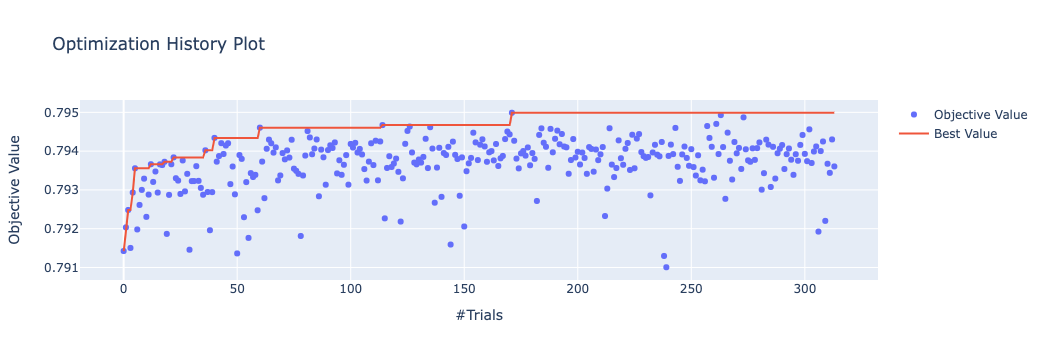

In [14]:
plot_optimization_history(study)

In [15]:
try:
    plot_param_importances(study)
except:
    pass

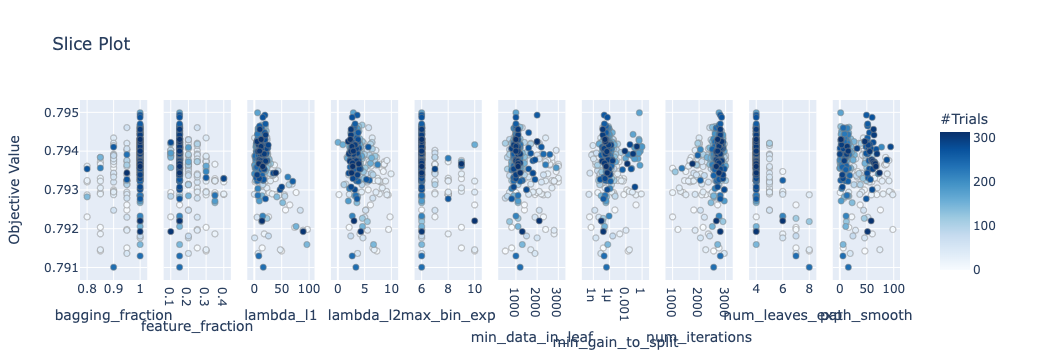

In [16]:
plot_slice(study)

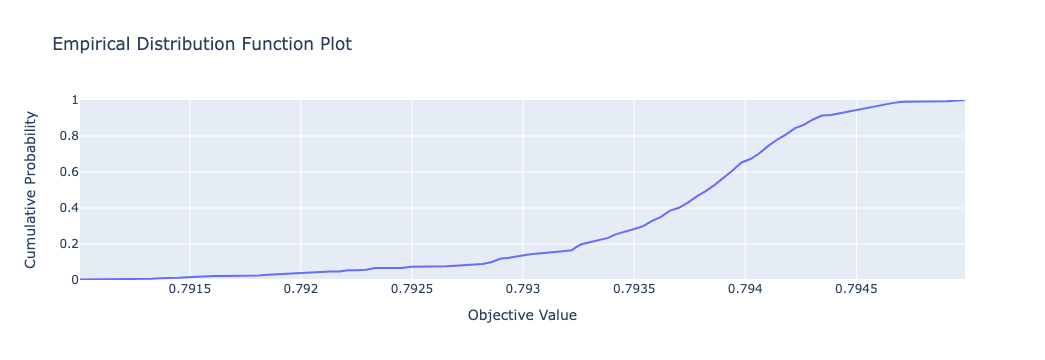

In [17]:
plot_edf(study)

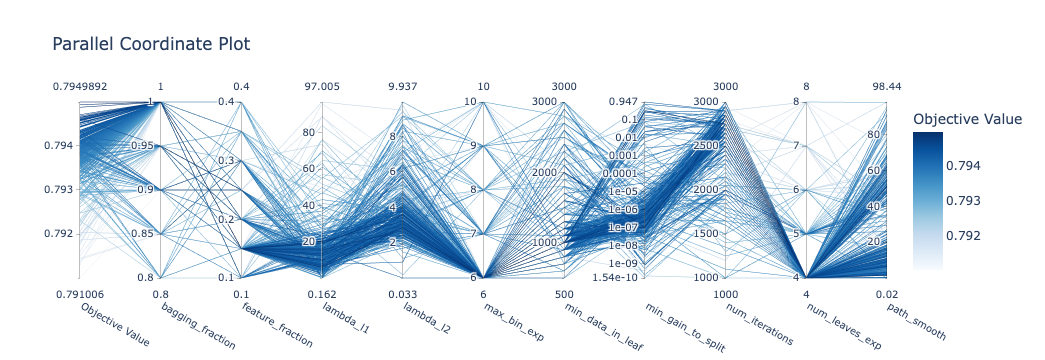

In [18]:
plot_parallel_coordinate(study)

In [19]:
best_params = dict(study.best_params)
best_params["max_bin"] = 2**best_params.pop("max_bin_exp")-1
best_params["num_leaves"] = 2**best_params.pop("num_leaves_exp")-1
best_params = {**default_params, **best_params}
best_params

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.05,
 'force_col_wise': True,
 'bagging_freq': 1,
 'seed': 2112,
 'verbosity': -1,
 'bin_construct_sample_cnt': 100000000,
 'feature_pre_filter': True,
 'bagging_fraction': 1.0,
 'feature_fraction': 0.15000000000000002,
 'lambda_l1': 5.996099571922015,
 'lambda_l2': 2.8900783163910697,
 'min_data_in_leaf': 1000,
 'min_gain_to_split': 0.313937968985787,
 'num_iterations': 2750,
 'path_smooth': 1.476306537276899,
 'max_bin': 63,
 'num_leaves': 15}

In [20]:
with open("../data/config/lgbm-bce-dsv04.yml", "w") as file:
    yaml.dump(best_params, file, default_flow_style=False)
    file.close()

***